In [106]:
# gestión de datos
import numpy as np
import pandas as pd
import sqlite3

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# guradar modelo
import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

In [4]:
con = sqlite3.connect("classic.db")

In [5]:
# Consulta de productos más vendidos y sus ingresos
q = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY ingresos_totales DESC
"""

pd.read_sql(q, con)



,productName,unidades_totales,ingresos_totales
0,1992 Ferrari 360 Spider red,1808,276839.98
1,2001 Ferrari Enzo,1019,190755.86
2,1952 Alpine Renault 1300,961,190017.96
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00
4,1968 Ford Mustang,933,161531.48
...,...,...,...
104,1982 Ducati 996 R,906,33268.76
105,1958 Chevy Corvette Limited Edition,983,31627.96
106,1982 Lamborghini Diablo,912,30972.87
107,1936 Mercedes Benz 500k Roadster,824,29763.39


In [6]:
# Consulta de participación porcentual de ingresos por producto
q = """
WITH ventas AS (
    SELECT 
        p.productName,
        SUM(od.quantityOrdered) AS unidades_totales,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
    INNER JOIN products p ON od.productCode = p.productCode
    GROUP BY p.productName)
SELECT 
    productName,
    unidades_totales,
    ingresos_totales,
    ROUND((ingresos_totales * 100.0) / (SELECT SUM(ingresos_totales) FROM ventas), 2) AS porcentaje_participacion
FROM ventas
ORDER BY ingresos_totales DESC
"""
pd.read_sql(q, con)


,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,0.35
105,1958 Chevy Corvette Limited Edition,983,31627.96,0.33
106,1982 Lamborghini Diablo,912,30972.87,0.32
107,1936 Mercedes Benz 500k Roadster,824,29763.39,0.31


In [7]:
# Calcular precio promedio de venta por unidad
q_unidad = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales,
    ROUND(SUM(od.quantityOrdered * od.priceEach) / NULLIF(SUM(od.quantityOrdered), 0), 2) AS precio_promedio_unidad
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY precio_promedio_unidad DESC
"""
pd.read_sql(q_unidad, con)




,productName,unidades_totales,ingresos_totales,precio_promedio_unidad
0,1952 Alpine Renault 1300,961,190017.96,197.73
1,2001 Ferrari Enzo,1019,190755.86,187.20
2,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,173.29
3,1968 Ford Mustang,933,161531.48,173.13
4,1969 Ford Falcon,965,152543.02,158.08
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,36.72
105,1936 Mercedes Benz 500k Roadster,824,29763.39,36.12
106,1982 Lamborghini Diablo,912,30972.87,33.96
107,1958 Chevy Corvette Limited Edition,983,31627.96,32.17


In [8]:
# conversion a dataframe y mostrar las primeras 10 filas
df_productos = pd.read_sql(q, con)
df_productos.head(10)

,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
5,1969 Ford Falcon,965,152543.02,1.59
6,1980s Black Hawk Helicopter,1040,144959.91,1.51
7,1998 Chrysler Plymouth Prowler,986,142530.63,1.48
8,1917 Grand Touring Sedan,918,140535.60,1.46
9,2002 Suzuki XREO,1028,135767.03,1.41


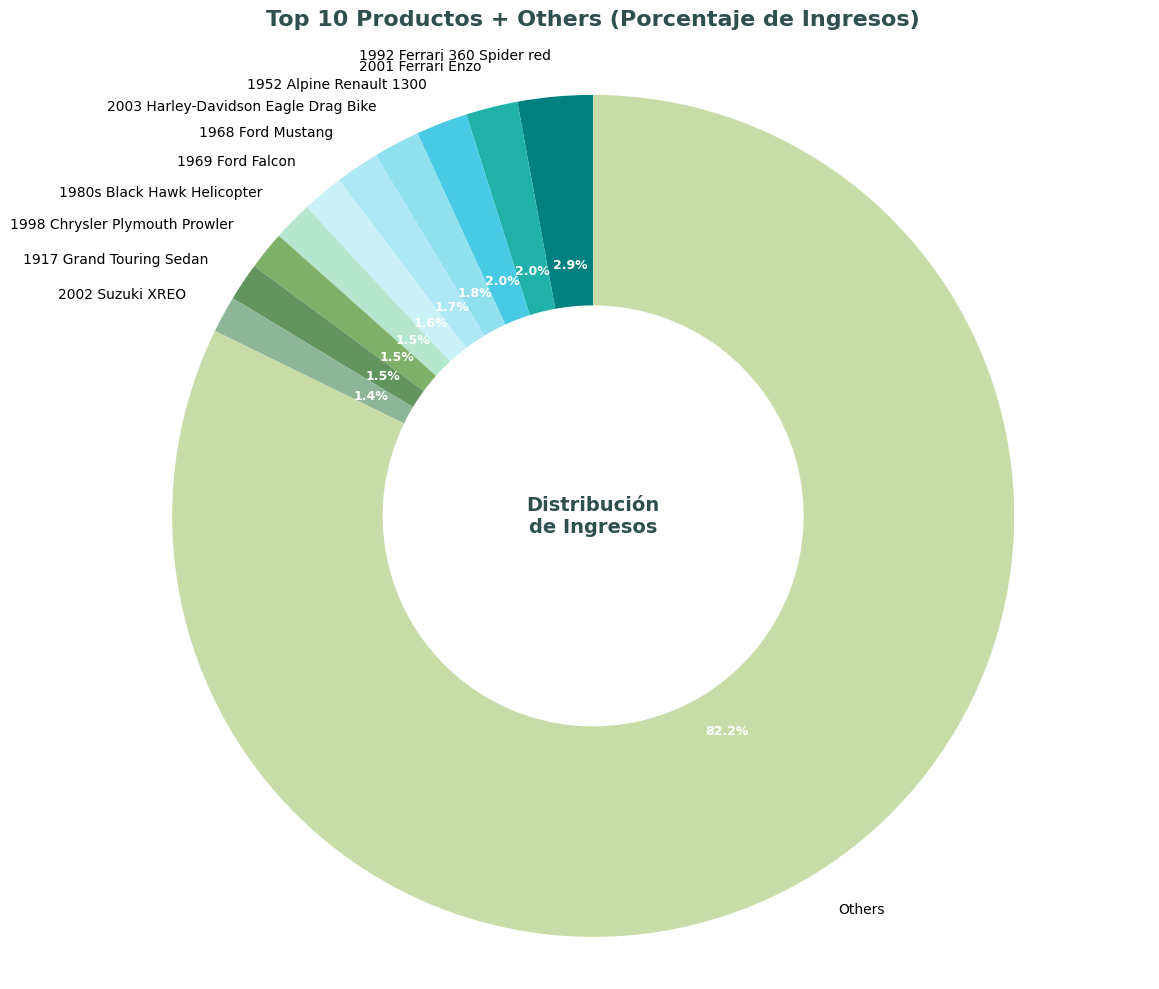

In [9]:
# Tomar los 10 primeros productos
df_top10 = df_productos.head(10)

# Calcular el total del resto
otros = pd.DataFrame({
    "productName": ["Others"],
    "porcentaje_participacion": [df_productos["porcentaje_participacion"].iloc[10:].sum()]
})

# Unir los 10 primeros con el grupo "Others"
df_plot = pd.concat([df_top10, otros], ignore_index=True)

# Crear paleta de colores con teal
colors = ['#008080', '#20B2AA', '#48CAE4', '#90E0EF', '#ADE8F4', 
          '#CAF0F8', '#B5E7CE', '#7FB069', '#629460', '#8DB596', '#C7DCA7']

# Graficar como dona
plt.figure(figsize=(12, 10))
wedges, texts, autotexts = plt.pie(
    df_plot["porcentaje_participacion"],
    labels=df_plot["productName"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.5),  # Esto crea el efecto de dona
    textprops={'fontsize': 10}
)

# Personalizar el texto de porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Añadir título en el centro de la dona
plt.text(0, 0, 'Distribución\nde Ingresos', 
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=14, 
         fontweight='bold',
         color='darkslategray')

plt.title("Top 10 Productos + Others (Porcentaje de Ingresos)", 
          fontsize=16, fontweight='bold', pad=20, color='darkslategray')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [10]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 0) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,34.0
1,P-51-D Mustang,28,32.0
2,HMS Bounty,28,32.0
3,F/A 18 Hornet 1/72,28,37.0
4,Diamond T620 Semi-Skirted Tanker,28,34.0
...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,34.0
105,1917 Grand Touring Sedan,25,36.0
106,1911 Ford Town Car,25,33.0
107,1957 Ford Thunderbird,24,31.0


In [11]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    SUM(od.quantityOrdered) AS unidades_totales,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 2) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_totales,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,1808,34.0
1,P-51-D Mustang,28,917,32.0
2,HMS Bounty,28,897,32.0
3,F/A 18 Hornet 1/72,28,1047,37.0
4,Diamond T620 Semi-Skirted Tanker,28,979,34.0
...,...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,866,34.0
105,1917 Grand Touring Sedan,25,918,36.0
106,1911 Ford Town Car,25,832,33.0
107,1957 Ford Thunderbird,24,767,31.0


INSIGHTS ESTRATÉGICOS:

TOP Frecuencia = Productos que siempre debes tener en stock

BOTTOM Frecuencia = Candidatos a descontinuar o revisar estrategia

In [12]:
# Consulta de ingresos mensuales
q_mes = """
SELECT 
    STRFTIME('%m', o.orderDate) AS mes_num,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_mensuales,
    SUM(od.quantityOrdered) AS unidades_vendidas
FROM orders o
INNER JOIN orderDetails od ON o.orderNumber = od.orderNumber
GROUP BY mes_num
ORDER BY mes_num
"""
pd.read_sql(q_mes, con)

,mes_num,ingresos_mensuales,unidades_vendidas
0,01,716815.00,7997
1,02,735098.65,7959
2,03,737920.36,8294
3,04,718244.98,7906
4,05,869235.79,9464
5,06,493841.51,5433
6,07,527503.85,5721
7,08,597584.20,6538
8,09,520497.65,5681
9,10,1014570.07,11214


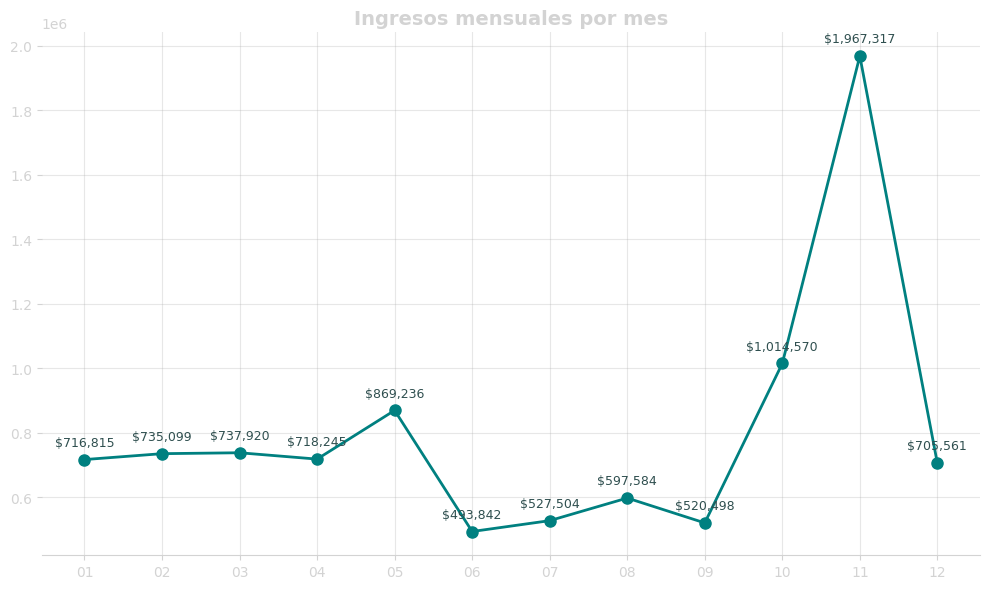

In [13]:
# Ejecutar la consulta
df_mes = pd.read_sql(q_mes, con)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(df_mes['mes_num'], df_mes['ingresos_mensuales'], marker='o', color='teal', linewidth=2, markersize=8)

# Añadir valores en cada punto
for i, (mes, ingreso) in enumerate(zip(df_mes['mes_num'], df_mes['ingresos_mensuales'])):
    plt.annotate(f'${ingreso:,.0f}', 
                (mes, ingreso), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9,
                color='darkslategray')

plt.xticks(df_mes['mes_num'])
plt.title('Ingresos mensuales por mes', color='lightgray', fontsize=14, fontweight='bold')

# Cambiar color de los ticks a gris claro
plt.tick_params(axis='x', colors='lightgray')
plt.tick_params(axis='y', colors='lightgray')

# Configurar spines (bordes del gráfico)
ax = plt.gca()
ax.spines['top'].set_visible(False)     # Ocultar borde superior
ax.spines['right'].set_visible(False)   # Ocultar borde derecho
ax.spines['left'].set_visible(False)    # Ocultar borde izquierdo
ax.spines['bottom'].set_color('lightgray')  # Eje X en gris claro

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ANÁLISIS:
### Estacionalidad de Ventas:
Meses pico: Octubre y Noviembre.

Meses bajos: Junio y Julio, nos sirve para planificar estrategias que sirvar para impulsar ventas.

Ciclos anuales: Entender patrones recurrentes del negocio y preparar el inventario.

### Estrategias de Marketing:
Campañas intensivas en meses bajos para activar ventas.

Aprovechamiento de meses naturalmente altos.

Presupuesto publicitario distribuido según estacionalidad.

In [14]:
q_pareto = """
SELECT 
    p.productName,
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY ingresos_totales DESC
"""

df_pareto = pd.read_sql(q_pareto, con)

df_pareto

,productName,ingresos_totales
0,1992 Ferrari 360 Spider red,276839.98
1,2001 Ferrari Enzo,190755.86
2,1952 Alpine Renault 1300,190017.96
3,2003 Harley-Davidson Eagle Drag Bike,170686.00
4,1968 Ford Mustang,161531.48
...,...,...
104,1982 Ducati 996 R,33268.76
105,1958 Chevy Corvette Limited Edition,31627.96
106,1982 Lamborghini Diablo,30972.87
107,1936 Mercedes Benz 500k Roadster,29763.39


In [15]:
# Calcular porcentajes acumulados
df_pareto['ingresos_acumulados'] = df_pareto['ingresos_totales'].cumsum()
total_ingresos = df_pareto['ingresos_totales'].sum()
df_pareto['porcentaje_acumulado'] = round(df_pareto['ingresos_acumulados'] / total_ingresos * 100, 2)
df_pareto['porcentaje_productos'] = ((df_pareto.index + 1) / len(df_pareto) * 100).round(2)


# ¿Cuántos productos generan el 80% de ingresos?
productos_80 = df_pareto[df_pareto['porcentaje_acumulado'] <= 80]
num_productos_80 = len(productos_80)
porcentaje_productos_80 = round(num_productos_80 / len(df_pareto) * 100, 2)

print(f"Total de productos: {len(df_pareto)}")
print(f"Ingresos totales: ${total_ingresos:,.2f}")

print(f"{num_productos_80} productos ({porcentaje_productos_80}%) generan el 80% de los ingresos")



Total de productos: 109
Ingresos totales: $9,604,190.61
71 productos (65.14%) generan el 80% de los ingresos


## ANÁLISIS DE PARETO (80/20)

### Resultado del Análisis:
De un total de 109 productos en el catálogo, 71 productos (65.14%) generan el 80% de los ingresos totales ($9,604,190.61).

### Interpretación:

Este resultado NO cumple estrictamente con la regla de Pareto clásica (20/80), la cual establece que aproximadamente el 20% de los productos deberían generar el 80% de los ingresos. En este caso, necesitamos el 65.14% de los productos para alcanzar el 80% de ingresos, lo que indica una **distribución más equilibrada** de las ventas entre el catálogo.

### Implicaciones Estratégicas:

**1. Diversificación del Portafolio:**
El negocio no depende excesivamente de unos pocos productos estrella, sino que tiene una base de ingresos más distribuida. Esto reduce el riesgo comercial, ya que la pérdida de ventas en algunos productos puede compensarse con otros.

**2. Gestión de Inventario:**
A diferencia de un escenario Pareto puro, donde se podría concentrar el inventario en pocos productos, aquí se requiere mantener stock de una mayor cantidad de productos (71 items) para asegurar el 80% de los ingresos. Esto implica mayor inversión en inventario y logística más compleja.

**3. Optimización de Recursos:**
Aunque 71 productos es un número significativo, aún representa una oportunidad de optimización: los 38 productos restantes (34.86% del catálogo) solo generan el 20% de los ingresos. Estos productos son candidatos para:
- Revisar estrategia de precios
- Evaluar descontinuación
- Minimizar niveles de stock

**4. Enfoque Comercial:**
El equipo de ventas debe concentrar esfuerzos en mantener y potenciar los 71 productos críticos, mientras se evalúa la viabilidad de los 38 productos de cola larga.

### Recomendaciones:

- **Prioridad Alta:** Asegurar disponibilidad constante de los 71 productos que generan el 80% de ingresos
- **Estrategia Comercial:** Implementar promociones cruzadas entre productos de alto y bajo rendimiento para equilibrar la distribución

# Convertir base de datos a data frame

In [51]:
# Query para predicción de ventas mensuales TOTALES
query = """
SELECT 
    STRFTIME('%Y-%m', o.orderDate) AS año_mes,
    STRFTIME('%Y', o.orderDate) AS year,
    STRFTIME('%m', o.orderDate) AS month,
    SUM(od.quantityOrdered) AS unidades_vendidas,
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales,
    COUNT(DISTINCT o.orderNumber) AS numero_ordenes,
    ROUND(AVG(od.quantityOrdered * od.priceEach), 2) AS ticket_promedio
FROM orders o
INNER JOIN orderDetails od ON o.orderNumber = od.orderNumber
GROUP BY STRFTIME('%Y-%m', o.orderDate), STRFTIME('%Y', o.orderDate), STRFTIME('%m', o.orderDate)
ORDER BY año_mes
"""

df = pd.read_sql(query, con)

    # Eliminar nulos
df = df.dropna()

# Guardar
df.to_csv('datos_ventas_mensuales.csv', index=False, encoding='utf-8')

print(f"Dataset: {len(df)} meses de datos")
df.head(10)

Dataset: 29 meses de datos


,año_mes,year,month,unidades_vendidas,ingresos_totales,numero_ordenes,ticket_promedio
0,2003-01,2003,01,1357,116692.77,5,2992.12
1,2003-02,2003,02,1449,128403.64,3,3131.80
2,2003-03,2003,03,1755,160517.14,6,3210.34
3,2003-04,2003,04,1993,185848.59,7,3204.29
4,2003-05,2003,05,2017,179435.55,6,3093.72
5,2003-06,2003,06,1685,150470.77,7,3201.51
6,2003-07,2003,07,2145,201940.36,7,3205.40
7,2003-08,2003,08,1974,178257.11,5,3073.40
8,2003-09,2003,09,2510,236697.85,8,3114.45
9,2003-10,2003,10,5731,514336.21,18,3136.20


In [82]:
# drop año_mes
df = df.drop(columns=['año_mes'])

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               29 non-null     object 
 1   month              29 non-null     object 
 2   unidades_vendidas  29 non-null     int64  
 3   ingresos_totales   29 non-null     float64
 4   numero_ordenes     29 non-null     int64  
 5   ticket_promedio    29 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ KB


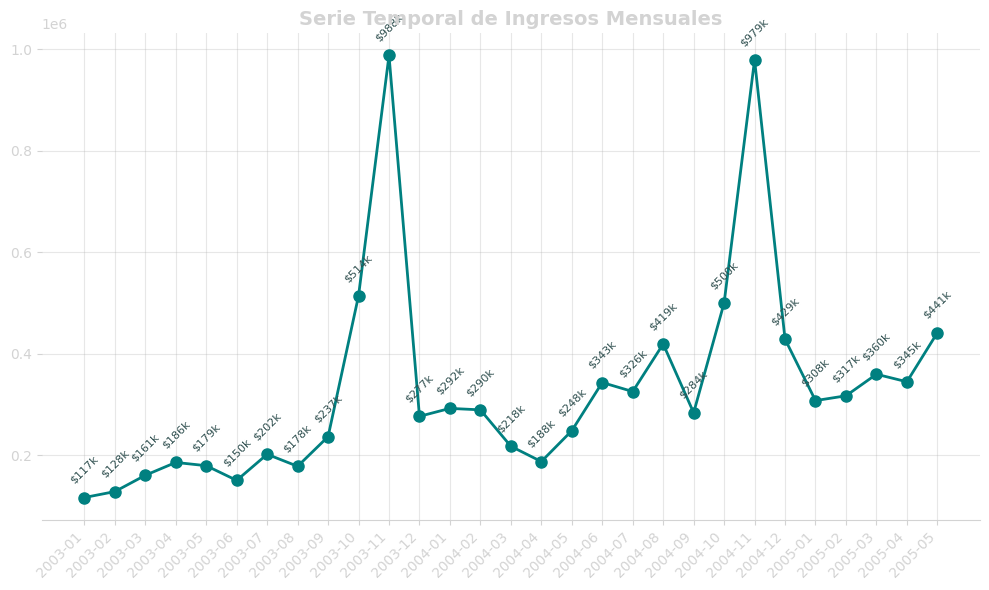

In [47]:
# Visualizar la serie temporal de ventas
plt.figure(figsize=(10, 6))
plt.plot(df['año_mes'], df['ingresos_totales'], marker='o', color='teal', linewidth=2, markersize=8)

# Añadir valores en cada punto (formato compacto en miles)
for i, (periodo, ingreso) in enumerate(zip(df['año_mes'], df['ingresos_totales'])):
    ingreso_k = ingreso / 1000  # Convertir a miles
    plt.annotate(f'${ingreso_k:.0f}k', 
                (periodo, ingreso), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center',
                fontsize=8,
                color='darkslategray',
                rotation=45)

plt.xticks(rotation=45, ha='right')
plt.title('Serie Temporal de Ingresos Mensuales', color='lightgray', fontsize=14, fontweight='bold')

# Cambiar color de los ticks a gris claro
plt.tick_params(axis='x', colors='lightgray')
plt.tick_params(axis='y', colors='lightgray')

# Configurar spines (bordes del gráfico)
ax = plt.gca()
ax.spines['top'].set_visible(False)     # Ocultar borde superior
ax.spines['right'].set_visible(False)   # Ocultar borde derecho
ax.spines['left'].set_visible(False)    # Ocultar borde izquierdo
ax.spines['bottom'].set_color('lightgray')  # Eje X en gris claro

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
df_final = df.copy()

In [85]:
target = 'ingresos_totales'

In [86]:
# separar por listas tipos de variables
def obtener_listas_tipos(df_final):
    lista_numerica=[]
    lista_categorica=[]
    lista_boolean=[]

    for i in df_final:
        if df_final[i].dtype in ("float64", "int64") and len(df_final[i].unique()) != 2 and i not in target:        
            lista_numerica.append(i)
        elif df_final[i].dtype in ("float64", "int64") and len(df_final[i].unique()) == 2 and i not in target:
            lista_boolean.append(i)
        elif df_final[i].dtype == "O" and i not in target:
            lista_categorica.append(i)
    return lista_numerica, lista_categorica, lista_boolean
lista_numerica, lista_categorica, lista_boolean = obtener_listas_tipos(df_final)


In [87]:
# Convertir year y month a numérico primero
df_final['year'] = df_final['year'].astype(int)
df_final['month'] = df_final['month'].astype(int)


Como no tenemos variables categricas no haremos get dummnies. En este caso solo usaremos minmax scaller para las numericas

In [89]:
print(lista_numerica)

['unidades_vendidas', 'numero_ordenes', 'ticket_promedio']


In [90]:
MinMax = MinMaxScaler()

In [91]:
# minmax scaller de numericas
df_final[lista_numerica] = MinMax.fit_transform(df_final[lista_numerica])


In [92]:
df_final.head()

,year,month,unidades_vendidas,ingresos_totales,numero_ordenes,ticket_promedio
0,2003,1,0.000000,116692.77,0.066667,0.046186
1,2003,2,0.009679,128403.64,0.000000,0.151511
2,2003,3,0.041873,160517.14,0.100000,0.210735
3,2003,4,0.066912,185848.59,0.133333,0.206173
4,2003,5,0.069437,179435.55,0.100000,0.122797


In [ ]:
# correlacion
corr = df_final.corr()

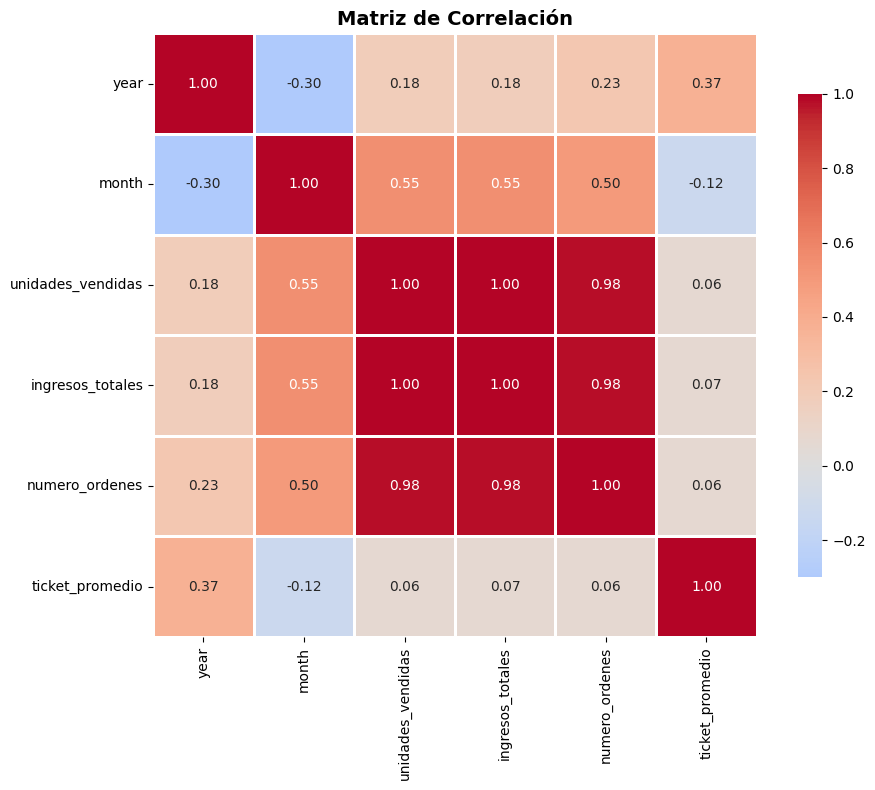

In [99]:
# Visualizar matriz de correlación con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [100]:
# hacer un pickle de df_final
df_final.to_pickle('df_final.pkl')

In [101]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               29 non-null     int64  
 1   month              29 non-null     int64  
 2   unidades_vendidas  29 non-null     float64
 3   ingresos_totales   29 non-null     float64
 4   numero_ordenes     29 non-null     float64
 5   ticket_promedio    29 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.5 KB


In [104]:
X = df_final.drop(columns=['ingresos_totales'], axis=1) # variables independientes
y = df_final['ingresos_totales'] # variable dependiente (a predecir)

In [21]:
# Dividir en train y test (80% train, 20% test)
# Importante: NO usar shuffle=True para datos temporales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False  # Mantener orden temporal
)

print(f"Train set: {X_train.shape[0]} meses")
print(f"Test set: {X_test.shape[0]} meses")

Train set: 20 meses
Test set: 5 meses


In [105]:
# separamos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [107]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_pred = lin_reg.predict(X_test)

minuto 2:14